# Data loading and EDA

In this notebook we are going to load the data, create a holdout set and do a bit of EDA.

We will also do preprocessing and data augmentation in this notebook, having the data prepared and ready for the model creating and evaluation

**Objectives**
- Data loading and creation of a holdout set
- Group together classes as required
- Check class balance
- Visualizing examples for each class
- Data augmentation
- Over or under sampling of the classes for class imbalance (if needed)

**Conclusions**
- Creation of a validation set that we will use for the training and early_stopping of the model
- Grouped together the classes and created a function to group labels for the test set in the next step
- Checked the class imbalance, there are 3 minority class, which we have upsampled using data augmentation in the last step
- Scaled the data from 0 to 255 to 0 to 1, so that we can use it for the model step
- Saved all the data throughout the notebook so that we can use it for the next step
- Created functions in the source code with tests which have been used in this notebook, for more information check the source code! :)

## Imports

In [1]:
%load_ext watermark
import random
import numpy as np
import seaborn as sns
import warnings
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-10-08 13:05:54.864542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%watermark

Last updated: 2023-10-08T13:05:58.512450+02:00

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.16.1

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [3]:
%watermark --iversions

keras     : 2.14.0
tensorflow: 2.14.0
matplotlib: 3.8.0
seaborn   : 0.13.0
numpy     : 1.26.0



## Loading the data and creating a holdout set

We are going to load the data from the keras library, as it's the same data as in the github repository linked in the task. The good thing about this is that the holdout set is already created, so we will save that holdout set and not be used until the end of the model validation, where we will test the best model in the training set with the test set.

Things to note about the images:
- They are in gray-scale so they only have one dimension per image, not RGB like the colour ones
- They are 28x28 pixels, so we may need to modify the input shape for the models we are going to use in this challenge
- There are 6k images in the training set and 1k images in the test set. The labels are stored in another array.

In [4]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
assert X_train.shape == (60000, 28, 28), "Shape of the training data is not as expected"
assert X_test.shape == (10000, 28, 28), "Shape of the test data is not as expected"
assert y_train.shape == (60000,), "Shape of the y labels for training data is not as expected"
assert y_test.shape == (10000,), "Shape of the y labels for test data is not as expected"

In [6]:
X_train[1,:]

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

In [7]:
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

### Saving the holdout set

In [8]:
np.save("../data/holdout_images", X_test)
np.save("../data/holdout_labels", y_test)

## Grouping together classes

For this section we have declared a function to map the original classes to the ones described by the challenge. The implementation can be seen inside the source code in the repository.

In [9]:
from centric.dataset import group_labels
from centric.constants import CLASS_NAMES

In [10]:
y_train = group_labels(y_train)

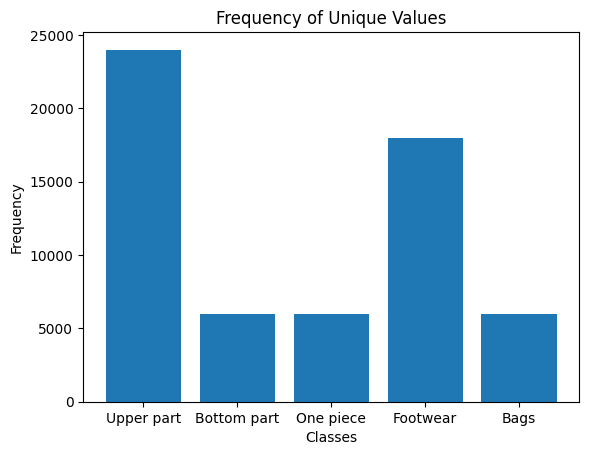

In [11]:
# Get unique values and their counts
values, counts = np.unique(y_train, return_counts=True)
# Create bar chart
plt.bar(CLASS_NAMES, counts)
plt.title('Frequency of Unique Values')
plt.xlabel('Classes')
plt.ylabel('Frequency')

# Show the plot
plt.show()

From the chart above we can see that the "Upper part" and "Footwear" classes are dominating the dataset, having around 20000 instances per class, while the other classes "Bottom part", "One piece" and "Bags" are much less populated. This can be explained because the upper part is the one with the highest grouping, involvong most of the original classes, and the footwear seems to be quite big in the fashion industry.

If we keed the dataset this way, the model will be biased towards the high majority classes, learning more about them and ignoring the minority classes. We could do data augmentation to just the minority classes so that we upsample those classes and balance a bit the datasetÇ

Another approach would be to augment in a higher rate the minority classes to address that imbalance.

## Creating a validation set, that will be used for the training of the model

We are going to save the a 20% of the training examples as validation set for the training of the model. Once, the model has been trained we will predict the test examples as as final test and measure.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
np.save("../data/validation_images", X_val)
np.save("../data/validation_labels", y_val)

## Visualizing images and classes

We are going to visualize 5 random examples for each of the classes, so that we can see how do they look like.

As shown in the group of images below, we see the expected images in each of the classes. Having a quick look at the different images, we can see that the model may have some difficulty with "upper parts" and "one pieces" as they are the most similar ones.
The other classes seem pretty identifiable and different from each other, so we won't incur in much problem with them.

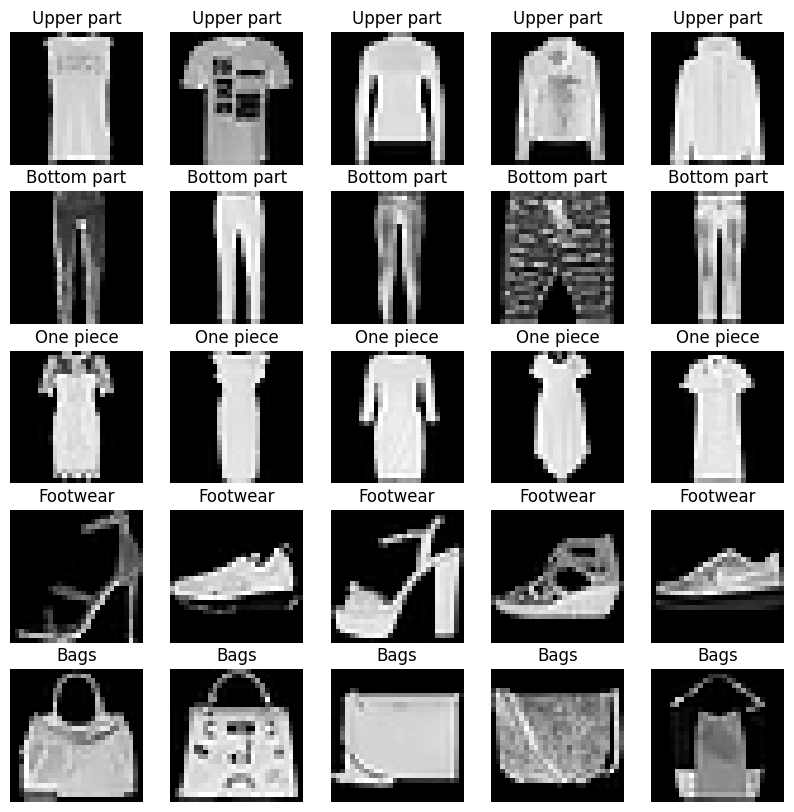

In [14]:
plt.figure(figsize=(10, 10))
img_count = 1

for i in range(len(np.unique(y_train))):
    for j in range(0,5):
      idx_class = np.where(y_train == i)[0]
      rnd_img = X_train[random.choice(idx_class)]
      ax = plt.subplot(5, 5, img_count)
      plt.imshow(rnd_img, cmap='gray', vmin=0, vmax=255)
      plt.title(CLASS_NAMES[i])
      plt.axis("off")
      img_count +=1

## Data augmentation - Upsampling

Instead of under sampling the majority class we are going to upsample the minority classes by applying data augmentation to them only. With this we will create new instances for those classes, while keeping the original images for the majority classes. Balancing a bit the datasets.

We are going to apply upsampling/data augmentation to the following classes:
- Bottom part - label 1
- One piece - label 2
- Bags - label 4

At the end of this section we will merge everything together again, rebuilding the training data.

I've done this part in the notebook and not in a function to just test with the different parameters of data augmentation and check that shapes and appends made sense. When productionizing the model and pipeline, we should move this to the source code with corresponding tests.

In [15]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.05),
])

### Bottom part - Label 1

In [16]:
index_bottom = np.where(y_train == 1)
X_bottom = X_train[index_bottom]

augmented_bottom = data_augmentation(X_bottom).numpy()
y_bottom_label = np.array([1 for x in range(len(augmented_bottom))])

X_train = np.append(X_train, augmented_bottom, axis=0)
y_train = np.append(y_train, y_bottom_label, axis = 0)

assert X_train.shape[1] == 28, "We've messed up with the dimensions of the array!"
assert X_train.shape[2] == 28, "We've messed up with the dimensions of the array!"

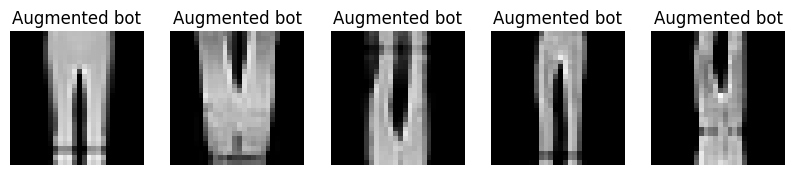

In [17]:
#Visualizing some augmented images
plt.figure(figsize=(10, 10))

for i in range(5):
  rnd_img = augmented_bottom[random.choice(range(len(augmented_bottom)))]
  ax = plt.subplot(1, 5, i+1)
  plt.imshow(rnd_img, cmap='gray', vmin=0, vmax=255)
  plt.title("Augmented bot")
  plt.axis("off")
  img_count +=1

### One piece - Label 2

In [18]:
index_one_piece = np.where(y_train == 2)
X_one_piece = X_train[index_one_piece]

augmented_one_piece = data_augmentation(X_one_piece).numpy()
y_one_piece_label = np.array([1 for x in range(len(augmented_one_piece))])

X_train = np.append(X_train, augmented_one_piece, axis=0)
y_train = np.append(y_train, y_one_piece_label, axis = 0)

assert X_train.shape[1] == 28, "We've messed up with the dimensions of the array!"
assert X_train.shape[2] == 28, "We've messed up with the dimensions of the array!"

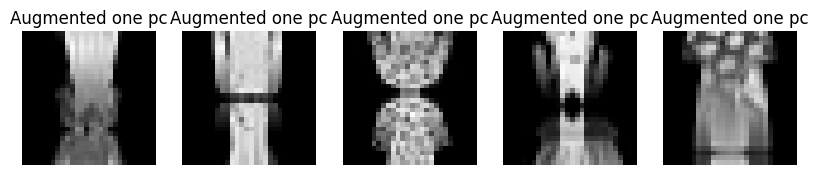

In [19]:
#Visualizing some augmented images
plt.figure(figsize=(10, 10))

for i in range(5):
  rnd_img = augmented_one_piece[random.choice(range(len(augmented_one_piece)))]
  ax = plt.subplot(1, 5, i+1)
  plt.imshow(rnd_img, cmap='gray', vmin=0, vmax=255)
  plt.title("Augmented one pc")
  plt.axis("off")
  img_count +=1

### Bags - Label 4

In [20]:
index_bags = np.where(y_train == 4)
X_bags = X_train[index_bags]

augmented_bags = data_augmentation(X_bags).numpy()
y_bags_labels = np.array([1 for x in range(len(augmented_bags))])

X_train = np.append(X_train, augmented_bags, axis=0)
y_train = np.append(y_train, y_bags_labels, axis = 0)

assert X_train.shape[1] == 28, "We've messed up with the dimensions of the array!"
assert X_train.shape[2] == 28, "We've messed up with the dimensions of the array!"

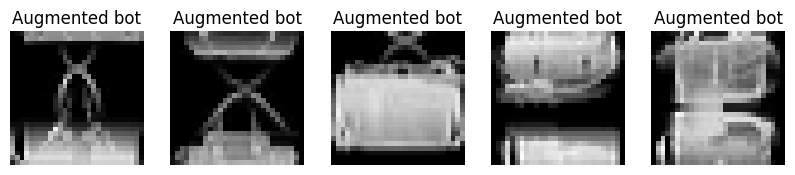

In [21]:
#Visualizing some augmented images
plt.figure(figsize=(10, 10))

for i in range(5):
  rnd_img = augmented_bags[random.choice(range(len(augmented_bags)))]
  ax = plt.subplot(1, 5, i+1)
  plt.imshow(rnd_img, cmap='gray', vmin=0, vmax=255)
  plt.title("Augmented bot")
  plt.axis("off")
  img_count +=1

In [22]:
X_train.shape

(62400, 28, 28)

## Rescaling the data

We are going to apply a simple rescaling before we put the data into the model, applying a division by 255. To produce numbers in our training examples from 0 to 1.


In [23]:
from centric.dataset import rescale_data

X_train = rescale_data(X_train)

assert X_train.shape == (62400, 28, 28)
assert np.max(X_train) == 1
assert np.min(X_train) == 0

## Saving the data for the model step

Saving the training data for the next step which will be the model creation and validation

In [24]:
np.save("../data/train_images", X_train)
np.save("../data/train_labels", y_train)